In [2]:
!pip install -q keras
!pip install -U keras-tuner

Requirement already up-to-date: keras-tuner in /usr/local/lib/python3.7/dist-packages (1.0.3)


In [8]:
import cv2
import pandas as pd
import numpy as np
import keras
import random 
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import torch
import IPython
import tensorflow as tf
%load_ext tensorboard
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
from keras.engine import input_layer
from keras.models import load_model
import kerastuner as kt
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pickle
import datetime, os
import time

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [9]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

Instructions for updating:
non-resource variables are not supported in the long term


# Define Globals

In [11]:
#Image Directory Path
full_path = './Dataset/Training'

#Image Subfolder
FULLDATADIR = full_path
CATEGORIES = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]


# Data Exploration

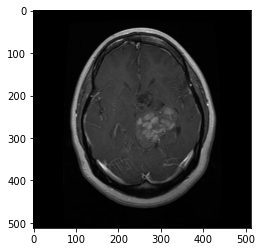

In [12]:
for category in CATEGORIES:
  path = os.path.join(FULLDATADIR, category)
  for img in os.listdir(path):
    img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
    plt.imshow(img_array, cmap="gray")
    plt.show()
    break
  break

In [13]:
print(img_array)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [14]:
img_array.shape

(512, 512)

In [15]:
print(img_array.min(), img_array.max())

0 249


Text(0.5, 1.0, 'Histogram of Pixel Intensity')

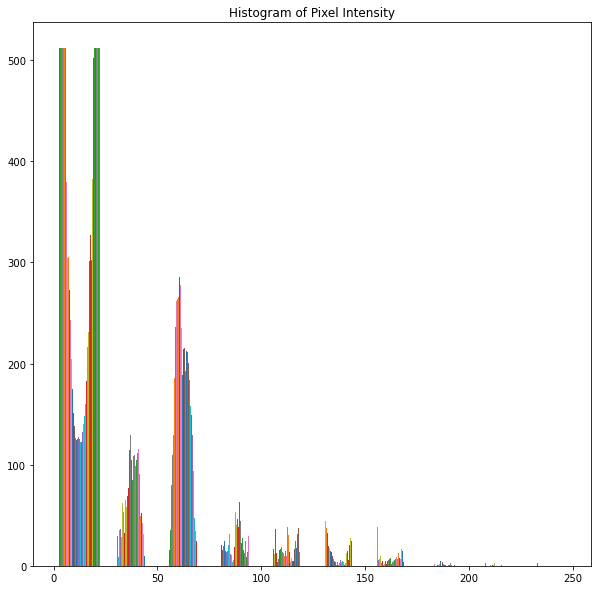

In [16]:
plt.figure(figsize=(10, 10))
plt.hist(img_array, histtype='bar', bins=10)
plt.title("Histogram of Pixel Intensity")

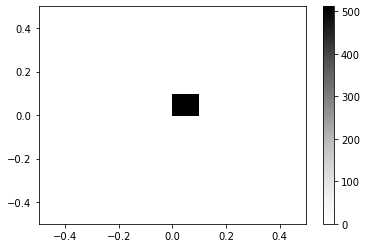

In [17]:
plt.hist2d(img_array[:,1], img_array[:,2], bins=(10,10), cmap=plt.cm.Greys)
plt.colorbar()

# Data Wrangling

In [18]:
# Convolutional Neural Network Re-Size
CONV_IMG_SIZE = 256

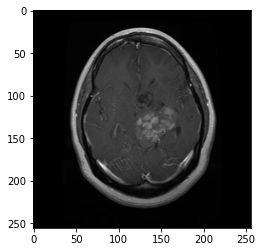

In [19]:
new_array = cv2.resize(img_array, (CONV_IMG_SIZE, CONV_IMG_SIZE))
plt.imshow(new_array, cmap="gray")
plt.show()

In [20]:
# Capsule Neural Network Re-Size
CAPS_IMG_SIZE = 56

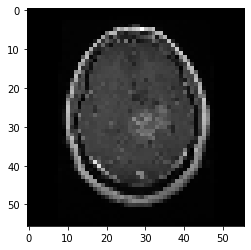

In [21]:
new_array = cv2.resize(img_array, (CAPS_IMG_SIZE, CAPS_IMG_SIZE))
plt.imshow(new_array, cmap="gray")
plt.show()

### Append Labels

In [22]:
caps_full_data = []

def create_full_caps_data():
  for category in CATEGORIES:
    path = os.path.join(FULLDATADIR, category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
        new_array = cv2.resize(img_array, (CAPS_IMG_SIZE, CAPS_IMG_SIZE))
        caps_full_data.append([new_array, class_num])
      except Exception as e:
        pass

create_full_caps_data()

In [23]:
len(caps_full_data)

2870

In [24]:
random.shuffle(caps_full_data)

In [25]:
for sample in caps_full_data[:10]:
  print(sample[1])

3
3
0
2
1
0
1
1
1
1


In [26]:
caps_full_training_x = []
caps_full_train_y = []

for features, label in caps_full_data:
  caps_full_training_x.append(features)
  caps_full_train_y.append(label)

# covert each of the pixel elements into a 1 element list (1 channel for grayscale)
caps_full_training_x = np.array(caps_full_training_x)
caps_full_train_x = caps_full_training_x.reshape(2870,56,56,1)

In [27]:
print(caps_full_train_x.shape)

(2870, 56, 56, 1)


## Save Input Data

In [30]:
# save the label capsule and feature info to the google drive
feature_info = 'caps_full_training_features.pt'
caps_path = "./brain_tumors/{feature_info}" 
torch.save(caps_full_train_x, caps_path)

label_info = 'caps_full_training_labels.pt'
caps_path ="./brain_tumors/{label_info}" 
torch.save(caps_full_train_y, caps_path)

FileNotFoundError: [Errno 2] No such file or directory: './brain_tumors/{feature_info}'

## Load Input Data

In [ ]:
# load the label capsule and feature info from the google drive
feature_info = 'caps_full_training_features.pt'
caps_path = F"/content/gdrive/My Drive/brain_tumors/{feature_info}" 
caps_x_saved = torch.load(caps_path)

label_info = 'caps_full_training_labels.pt'
caps_path = F"/content/gdrive/My Drive/brain_tumors/{label_info}" 
caps_y_saved = torch.load(caps_path)

### Reset the default graph and set the random seed

In [ ]:
tf.reset_default_graph()
np.random.seed(42)
tf.set_random_seed(42)

### Ancillary Functions

In [ ]:
# Create output vectors with length <= 1, Epsilon value is designed to avoid a 'divide by zero' error
def squash_fn(s, axis=-1, epsilon=1e-7, name=None):
  with tf.name_scope(name, default_name="squash_fn"):
    squared_norm = tf.reduce_sum(tf.square(s), axis=axis, keepdims=True)
    safe_norm = tf.sqrt(squared_norm + epsilon)
    squash_factor = squared_norm / (1. + squared_norm)
    unit_vector = s / safe_norm

    return squash_factor * unit_vector


#Normalize the output of the output label vectors (avoid 'divide by zero' error)
def safe_norm(s, axis=-1, epsilon=1e-7, keepdims=False, name=None):
  with tf.name_scope(name, default_name="safe_norm"):
    squared_norm = tf.reduce_sum(tf.square(s), axis=axis, keepdims=keepdims)

    return tf.sqrt(squared_norm + epsilon)

### Re-shape Data, Assign Data Type, Train-Test-Validation Split

In [ ]:
x_data, y_data = caps_x_saved, caps_y_saved
x_data.shape

In [ ]:
full_x_data = x_data.reshape(2870,56,56)
full_x_data.shape

In [ ]:
# Set data types
full_x_data = full_x_data.astype('float32')
train_y = np.asarray(y_data, dtype=np.int32)

# Scale data set
full_x_data /= 255

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(full_x_data, y_data, test_size = 0.2, random_state=25)

In [ ]:
train_X, train_y, val_X, val_y = train_X[0:2570], train_y[0:2570], train_X[2570:], train_y[2570:] # 12.7%

In [ ]:
train_X[0][10]

In [ ]:
n_samples = 5

plt.figure(figsize=(n_samples * 5, 5))
for index in range(n_samples):
  plt.subplot(1, n_samples, index + 1)
  sample_image = train_X[index].reshape(56, 56)
  plt.imshow(sample_image, cmap="gray")
  plt.axis("off")

In [ ]:
train_y[:n_samples]

### Define the network

In [ ]:
# Create placeholder for the input images
X = tf.placeholder(shape=[None, 56, 56, 1], dtype=tf.float32, name="X")

In [ ]:
# Set up the primary capsule layer, size of each 2D capsule map determined by the kernel size, padding and stride values
primary_capsule_maps = 32 
num_primary_capsules = primary_capsule_maps * 20 * 20  #12,800 primary capsules (20)
primary_capsule_dims = 8  

In [ ]:
# Define the convolutional layers that will feed into the primary capsule layer
conv1_params = {
  "filters": 256,
  "kernel_size": 9, 
  "strides": 1,
  "padding": "valid",
  "activation": tf.nn.relu,
}

conv2_params = {
  "filters": primary_capsule_maps * primary_capsule_dims, # 256 convolutional filters
  "kernel_size": 9, 
  "strides": 2,
  "padding": "valid",
  "activation": tf.nn.relu
}

In [ ]:
conv1 = tf.layers.conv2d(X, name="conv1", **conv1_params)
conv2 = tf.layers.conv2d(conv1, name="conv2", **conv2_params)

In [ ]:
# Flattened raw output of the primary capsule layer (batch size, 2D capsule map X num capsule maps, dimension of each capsule)
raw_caps = tf.reshape(conv2, [-1, num_primary_capsules, primary_capsule_dims], name="raw_caps")

# Squash the output vectors
primary_output_caps = squash_fn(raw_caps, name="primary_output_caps")

In [ ]:
# Set up the second capsule layer for the labels, and capsule dimensions
caps2_n_caps = 4 
caps2_n_dims = 16 

### Compute Label Capsule Predictions

In [ ]:
# Create a variable that will hold all of the trainable label prediction transformation matrices
sigma = 0.1

Weight_init = tf.random_normal(shape=(1, num_primary_capsules, caps2_n_caps, caps2_n_dims, primary_capsule_dims), stddev=sigma, dtype=tf.float32, name="Weight_init")
Weights = tf.Variable(Weight_init, name="Weights")

# Create an array with one identical matrix variable per instance in the data set
batch_size = tf.shape(X)[0]
W_tiled = tf.tile(Weights, [batch_size, 1, 1, 1, 1], name="W_tiled")
W_tiled

In [ ]:
# Create an array that will hold the output for each of the primary capsules multiplied by the number of label categories, the dimension is expanded for 'RBA' matrix multiplication
ext_primary_output_caps = tf.expand_dims(primary_output_caps, -1, name="ext_primary_output_caps")
caps1_output_tile = tf.expand_dims(ext_primary_output_caps, 2, name="caps1_output_tile")
caps1_output_tiled = tf.tile(caps1_output_tile, [1, 1, caps2_n_caps, 1, 1], name="caps1_output_tiled") 
caps1_output_tiled # increased rank

In [ ]:
# Multiply the two arrays together to get all of the label capsule predictions
caps2_predicted = tf.matmul(W_tiled, caps1_output_tiled, name="caps2_predicted")
caps2_predicted

### Perform Routing by Agreement

In [ ]:
# Round 1 -->

# Initialize and compute the routing weights by applying the softmax function to the primary capsule outputs
raw_weights = tf.zeros([batch_size, num_primary_capsules, caps2_n_caps, 1, 1], dtype=np.float32, name="raw_weights")
routing_weights = tf.nn.softmax(raw_weights, axis=2, name="routing_weights")

# Compute the weighted sum with the label prediction capsules 
weighted_predictions = tf.multiply(routing_weights, caps2_predicted, name="weighted_predictions") # automatically 'broadcasts' the routing weights by the label dim size along the 4th dimension
weighted_sum = tf.reduce_sum(weighted_predictions, axis=1, keepdims=True, name="weighted_sum")

# Squash the wighted sum to get the output of the 1st round of 'RBA'
caps2_output_round_1 = squash_fn(weighted_sum, axis=-2, name="caps2_output_round_1")

# Get the scalar product (agreement) of the RBA round 1 output and the label predictions by performing an element-wise matrix multiplication
caps2_output_round_1_tiled = tf.tile(caps2_output_round_1, [1, num_primary_capsules, 1, 1, 1], name="caps2_output_round_1_tiled") # re-shape so there is one multiplication operation per label
agreement = tf.matmul(caps2_predicted, caps2_output_round_1_tiled, transpose_a=True, name="agreement")

In [ ]:
# Round 2 -->

# Duplicate the same operations with the round 1 agreement scalar value to get the output label vectors based on agreement with the predictions
raw_weights_round_2 = tf.add(raw_weights, agreement, name="raw_weights_round_2")
routing_weights_round_2 = tf.nn.softmax(raw_weights_round_2, axis=2, name="routing_weights_round_2")
weighted_predictions_round_2 = tf.multiply(routing_weights_round_2, caps2_predicted, name="weighted_predictions_round_2")
weighted_sum_round_2 = tf.reduce_sum(weighted_predictions_round_2, axis=1, keepdims=True, name="weighted_sum_round_2")
caps2_output_round_2 = squash_fn(weighted_sum_round_2, axis=-2, name="caps2_output_round_2")

In [ ]:
# Output label vectors
caps2_output = caps2_output_round_2
caps2_output

### Compute the class label probabilities

In [ ]:
# Compute the length of the output vectors which correspond to the class probabilities
y_proba = safe_norm(caps2_output, axis=-2, name="y_proba")
y_proba_argmax = tf.argmax(y_proba, axis=2, name="y_proba")
y_proba_argmax # the index of the longest vector corresponds to the class label 

# Remove unnecessary dimensions
y_pred = tf.squeeze(y_proba_argmax, axis=[1,2], name="y_pred")
y_pred

### Compute the margin loss

In [ ]:
# Margin loss constants
m_plus = 0.9
m_minus = 0.1
lambda_ = 0.5

In [ ]:
# Create a placeholder for the labels in one hot encoded format corresponding to num labels
y = tf.placeholder(shape=[None], dtype=tf.int64, name="y")
T = tf.one_hot(y, depth=caps2_n_caps, name="T")

with tf.Session():
  print(T.eval(feed_dict={y: np.array([0, 1, 2, 3, 9])}))

In [ ]:
# The length of the instantiation vector represents the probability that a capsule's entity is present in the scene.
# A top-level capsule has a long vector if and only if its associated entity is present.
# To allow for multiple entities, a separate margin loss is computed for each capsule.
# Downweighting the loss for absent entities stops the learning from shrinking activity vector lengths for all entities.

caps2_output_norm = safe_norm(caps2_output, axis=-2, name="caps2_output_norm")

present_error_raw = tf.square(tf.maximum(0., m_plus - caps2_output_norm), name="present_error_raw")
present_error = tf.reshape(present_error_raw, shape=(-1, 4), name="present_error") # 10

absent_error_raw = tf.square(tf.maximum(0., caps2_output_norm - m_minus), name="absent_error_raw")
absent_error = tf.reshape(absent_error_raw, shape=(-1, 4), name="absent_error") # 10

In [ ]:
# Compute the margin loss value for each instance multiplied by each label
L = tf.add(T * present_error, lambda_ * (1.0 - T) * absent_error, name="L")

In [ ]:
# Sum the losses per label and calculate the mean value by data onservation instance
margin_loss = tf.reduce_mean(tf.reduce_sum(L, axis=1), name="margin_loss")

In [ ]:
# Force the capsule network to preserve all information required to reconstruct the baseline images. This limits overfitting (increases generalization)

# Create a mask so that only the output vector for the capsule that corresponds to the target label is evaluated
mask_with_labels = tf.placeholder_with_default(False, shape=(), name="mask_with_labels")

# Use the ground truths for training, otherwise use the prediction values (unsupervised learning)
reconstruction_targets = tf.cond(mask_with_labels, # condition
                                 lambda: y,        # if True
                                 lambda: y_pred,   # if False
                                 name="reconstruction_targets")

#Array value is 1.0 for the target class, otherwise 0,0
reconstruction_mask = tf.one_hot(reconstruction_targets, depth=caps2_n_caps, name="reconstruction_mask")

reconstruction_mask

In [ ]:
caps2_output

In [ ]:
# Re-shape the reconstruction mask by increasing the rank in order to make the multiplication possible
reconstruction_mask_reshaped = tf.reshape(reconstruction_mask, [-1, 1, caps2_n_caps, 1, 1], name="reconstruction_mask_reshaped")
caps2_output_masked = tf.multiply(caps2_output, reconstruction_mask_reshaped, name="caps2_output_masked")
caps2_output_masked

In [ ]:
# Flatten the decoder inputs
decoder_input = tf.reshape(caps2_output_masked, [-1, caps2_n_caps * caps2_n_dims], name="decoder_input")
decoder_input

In [ ]:
# The Decoder is a 3 Layer Dense Network
n_hidden1 = 512
n_hidden2 = 1024
n_output = 56 * 56 

with tf.name_scope("decoder"):
  hidden1 = tf.layers.dense(decoder_input, n_hidden1, activation=tf.nn.relu, name="hidden1")
  hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
  decoder_output = tf.layers.dense(hidden2, n_output, activation=tf.nn.sigmoid, name="decoder_output")

In [ ]:
# Mean squared difference between the input values
X_flat = tf.reshape(X, [-1, n_output], name="X_flat")
squared_difference = tf.square(X_flat - decoder_output, name="squared_difference")
reconstruction_loss = tf.reduce_mean(squared_difference, name="reconstruction_loss")

### Compute Final Loss

In [ ]:
# The final loss is a weighted sum between the margin loss and the reconstruction loss which emphasizes the former value
alpha = 0.0005
loss = tf.add(margin_loss, alpha * reconstruction_loss, name="loss")

### Evaluate Network accuracy

In [ ]:
correct = tf.equal(y, y_pred, name="correct")
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

### Initialize Optimizer and TF Values

In [ ]:
optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(loss, name="training_op")

In [ ]:
init = tf.global_variables_initializer()
saver = tf.train.Saver(save_relative_paths=True)

### Run the capsule Training Algorithm

In [ ]:
# Training loop parameters
n_epochs = 10
batch_size = 50
restore_checkpoint = True

n_iterations_per_epoch = len(train_X) // batch_size
n_iterations_validation = len(val_X) // batch_size
best_loss_val = np.infty

In [ ]:
checkpoint_path = '/content/gdrive/MyDrive/brain_tumors/brain_capsule_network/'

In [ ]:
#Training loop body
with tf.Session() as sess:
    if restore_checkpoint and tf.train.checkpoint_exists(checkpoint_path):
         saver.restore(sess, checkpoint_path)
    else:
        init.run()

    for epoch in range(n_epochs):
        for iteration in range(1, n_iterations_per_epoch + 1):
            start = (iteration-1)*batch_size
            stop = iteration*batch_size
            X_batch, y_batch = train_X[start:stop], train_y[start:stop]
            # Run the training operation and measure the loss:
            _, loss_train = sess.run(
                [training_op, loss],
                feed_dict={X: X_batch.reshape([-1, 56, 56, 1]),
                           y: y_batch,
                           mask_with_labels: True})
            print("\rIteration: {}/{} ({:.1f}%)  Loss: {:.5f}".format(
                      iteration, n_iterations_per_epoch,
                      iteration * 100 / n_iterations_per_epoch,
                      loss_train),
                  end="")

        # At the end of each epoch, measure the validation loss and accuracy:
        loss_vals = []
        acc_vals = []
        for iteration in range(1, n_iterations_validation + 1):
            start = (iteration-1)*batch_size
            stop = iteration*batch_size
            X_batch, y_batch = val_X[start:stop], val_y[start:stop]   
            loss_val, acc_val = sess.run(
                    [loss, accuracy],
                    feed_dict={X: X_batch.reshape([-1, 56, 56, 1]),
                               y: y_batch})
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
            print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                      iteration, n_iterations_validation,
                      iteration * 100 / n_iterations_validation),
                  end=" " * 10)
        loss_val = np.mean(loss_vals)
        acc_val = np.mean(acc_vals)
        print("\rEpoch: {}  Val accuracy: {:.4f}%  Loss: {:.6f}{}".format(
            epoch + 1, acc_val * 100, loss_val,
            " (improved)" if loss_val < best_loss_val else ""))

        # And save the model if it improved:
        if loss_val < best_loss_val:
            save_path = saver.save(sess, checkpoint_path)
            best_loss_val = loss_val

### Evaluate Model Performance

In [ ]:
n_iterations_test = len(test_X)// batch_size

with tf.Session() as sess:
  saver.restore(sess, checkpoint_path)
  sess.run(tf.global_variables_initializer())

  loss_tests = []
  acc_tests = []
  for iteration in range(1, n_iterations_test + 1):
    start = (iteration-1)*batch_size
    stop = iteration*batch_size
    X_batch, y_batch = test_X[start:stop], test_y[start:stop]   
    loss_test, acc_test = sess.run(
            [loss, accuracy],
            feed_dict={X: X_batch.reshape([-1, 56, 56, 1]), y: y_batch})
    loss_tests.append(loss_test)
    acc_tests.append(acc_test)
    print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
              iteration, n_iterations_test,
              iteration * 100 / n_iterations_test), end=" " * 10)
  loss_test = np.mean(loss_tests)
  acc_test = np.mean(acc_tests)
  print("\rFinal test accuracy: {:.4f}%  Loss: {:.6f}".format(
      acc_test * 100, loss_test))

In [ ]:
n_iterations_test = len(test_X)// batch_size
batch_labels = []
predictions = []

with tf.Session() as sess:
  saver.restore(sess, checkpoint_path)
  sess.run(tf.global_variables_initializer())

  for iteration in range(1, n_iterations_test + 1):
    start = (iteration-1)*batch_size
    stop = iteration*batch_size
    X_batch, y_batch = test_X[start:stop], test_y[start:stop]   
    batch_labels.append(sess.run(
          [y_pred],
          feed_dict={X: X_batch.reshape([-1, 56, 56, 1]), y: y_batch}))

  for i in range(len(batch_labels)):
    for j in range(len(batch_labels[i])):
      for k in range(len(batch_labels[i][j])):
        predictions.append(batch_labels[i][j][k])

  test_vals = test_y[0:700]
  con_mat = confusion_matrix(test_vals, predictions)
  con_df = pd.DataFrame(data=con_mat, index=CATEGORIES, columns=CATEGORIES)

  print(con_df)
  print('\n')

  # accuracy: (tp + tn) / (p + n)
  accuracy = accuracy_score(test_vals, predictions)
  print('Accuracy: %f' % accuracy)
  # precision tp / (tp + fp)
  precision = precision_score(test_vals, predictions, average='weighted')
  print('Precision: %f' % precision)
  # recall: tp / (tp + fn)
  recall = recall_score(test_vals, predictions, average='weighted')
  print('Recall: %f' % recall)
  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(test_vals, predictions, average='weighted')
  print('F1 score: %f' % f1)


# Capsule Result Summary

This Neural Network is composed of a primary capsule layer and a classification capsule layer. The primary layer re-shapes the input from a dense framework of two convolutional layers to create the initial vectors (capsules). Each of these convolutional layers  contains 256 filters (nodes), a 9x9 kernel and a stride length of one and two respectively. The output of the convolutional layers are used to build the primary layer of 12,800 capsules broken down into 32 20x20 maps of eight dimensional vectors. The architecture culminates in a classification capsule layer composed of four 16 dimensional vectors.

Information is selectively disseminated between nodes in the two capsule layers via a 'Routing by Agreement' algorithm allowing the network to gradually train itself to identify relevant classification features by matching pose predictions about relevant object subcomponents. The network outputs label probabilities and captures a weighted aggregation of 'margin' and 'reconstruction' losses for each instance before performing back propagation. The process of reconstruction regularizes the model and relies on the implementation of a decoder sub-network that rebuilds input images from capsule network outputs. The decoder has a dense 3 layer feed forward structure with node sizes corresponding to 512, 1024 and 3,136 (56 x 56) respectively. The margin loss helps to mininmize 'noise' and identify overlapping objects by providing a mechanism to determine percentage of a particular class that is present within each image.

**The netowrk was trained for 30 epochs with a batch size of 50 and achieved 98% accuracy on the test data including precision and recall.**